<div style="text-align: center">
    <img src="public/banner.png" width="600" alt="Banner" style="border-radius: 8px">
    <h1><strong>A study of Poles' psychedelic and non-psychedelic mystical experiences in relation to fear of death, emotional empathy, and life satisfaction</strong></h1>
</div>
<div style="text-align: center">
    <h3><strong>Part II: Lingustic analysis</strong></h1>
</div>

# **Imports**

## **Importing libraries**

In [112]:
import pandas as pd
import numpy as np
import requests
import warnings
import re
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from wordcloud import STOPWORDS, WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from collections import Counter
from scipy.stats import pearsonr
from PIL import Image, ImageDraw
from transformers import pipeline
from IPython.display import display, HTML

## **Loading dataset**

In [113]:
dataset_path = "public/dataset.xlsx"
df = pd.read_excel(dataset_path)

# **Data wrangling and cleaning**

## **Joining female and male variables into one dataframe**

In [114]:
columns_to_process = [col[:-2] for col in df.columns if col.endswith("_M")]
combined_columns = {}

for col in columns_to_process:
    male_col = f"{col}_M"
    female_col = f"{col}_F"
    
    if df[male_col].dtype == "float64" and df[female_col].dtype == "float64":
        male_variables = pd.to_numeric(df[male_col], errors="coerce").fillna(0)
        female_variables = pd.to_numeric(df[female_col], errors="coerce").fillna(0)
        
        combined_columns[col] = male_variables + female_variables
        
    elif df[male_col].dtype == "object" and df[female_col].dtype == "object":
        male_variables = df[male_col].fillna("")
        female_variables = df[female_col].fillna("")
        
        combined_columns[col] = male_variables + female_variables

combined_df = pd.DataFrame(combined_columns)

df = pd.concat([df, combined_df], axis=1)

df.drop(columns=[f"{col}_M" for col in columns_to_process] + [f"{col}_F" for col in columns_to_process], inplace=True)

pd.set_option("display.max_columns", None)
df.head()

,start_date,end_date,progress_in_percent,duration_in_seconds,finished,recorded_date,age,sex,survey_version,worldview,education,meditation,compound_never,compound_LSD,compound_psylocybin,compound_ayahuasca,compound_DMT,compound_5MeODMT,compound_mescaline,compound_ibogaine,compound_salvia,compound_other,compound_text,use_amount,microdose,low_dose,average_dose,high_dose,very_high_dose,mystical_experience,context_psychedelic,context_other_psychoactive,context_NDE,context_meditation,context_ritual,context_hypnosis,context_other,context_other_psychoactive_text,context_other_text,trigger_compound,order,intensity,how_long_ago,MEQ30_1,MEQ30_2,MEQ30_3,MEQ30_4,MEQ30_5,MEQ30_6,MEQ30_7,MEQ30_8,MEQ30_9,MEQ30_10,MEQ30_11,MEQ30_12,MEQ30_13,MEQ30_14,MEQ30_15,MEQ30_16,MEQ30_17,MEQ30_18,MEQ30_19,MEQ30_20,MEQ30_21,MEQ30_22,MEQ30_23,MEQ30_24,MEQ30_25,MEQ30_26,MEQ30_27,MEQ30_28,MEQ30_29,MEQ30_30,PES_1,PES_2,PES_3,PES_4,PES_5,PES_6,PES_7,PES_8,PES_9,PES_10,PES_11,SWLS_1,SWLS_2,SWLS_3,SWLS_4,SWLS_5,DAP_R_1,DAP_R_2,DAP_R_3,DAP_R_4,DAP_R_5,DAP_R_6,DAP_R_7,DAP_R_8,influence_empathy,influence_satisfaction,influence_fear,description_text
0,2023-02-17 22:50:49,2023-02-17 23:04:08,100,798,1,2023-02-17 23:04:09,28.0,1.0,1.0,2.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,6.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,,,2.0,0.0,0.0,4.0,6.0,6.0,6.0,6.0,6.0,4.0,5.0,5.0,5.0,6.0,5.0,4.0,6.0,5.0,5.0,5.0,4.0,6.0,5.0,5.0,5.0,6.0,5.0,4.0,4.0,5.0,5.0,5.0,6.0,5.0,4.0,4.0,2.0,5.0,2.0,4.0,3.0,3.0,4.0,4.0,2.0,3.0,4.0,2.0,1.0,3.0,5.0,6.0,7.0,5.0,6.0,7.0,7.0,5.0,2.0,2.0,2.0,
1,2023-02-18 00:24:48,2023-02-18 00:34:16,100,567,1,2023-02-18 00:34:18,30.0,1.0,1.0,4.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,2.0,5.0,3.0,2.0,2.0,3.0,4.0,2.0,1.0,5.0,4.0,4.0,3.0,4.0,3.0,1.0,2.0,3.0,1.0,4.0,4.0,2.0,0.0,0.0,0.0,
2,2023-02-18 12:57:58,2023-02-18 13:13:33,100,934,1,2023-02-18 13:13:33,25.0,2.0,2.0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Haszysz,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Ciastko z haszyszem,,0.0,0.0,0.0,52.0,6.0,4.0,6.0,5.0,6.0,4.0,6.0,4.0,6.0,6.0,6.0,3.0,6.0,5.0,5.0,5.0,3.0,4.0,6.0,4.0,5.0,6.0,1.0,3.0,2.0,5.0,1.0,5.0,6.0,1.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,1.0,2.0,1.0,5.0,2.0,2.0,2.0,1.0,3.0,3.0,4.0,
3,2023-02-18 13:14:33,2023-02-18 13:18:33,100,239,1,2023-02-18 13:18:34,22.0,2.0,2.0,4.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,2.0,3.0,2.0,3.0,4.0,3.0,2.0,3.0,4.0,2.0,2.0,3.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,0.0,0.0,0.0,
4,2023-02-18 13:19:13,2023-02-18 13:26:12,100,419,1,2023-02-18 13:26:13,28.0,2.0,2.0,4.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,2.0,2.0,3.0,3.0,2.0,3.0,4.0,3.0,3.0,4.0,5.0,5.0,6.0,5.0,3.0,2.0,2.0,5.0,2.0,3.0,2.0,2.0,0.0,0.0,0.0,


## **Recoding MEQ30 scorings**

In [115]:
meq30_columns = [col for col in df.columns if col.startswith("MEQ30")]

replacement_mapping = {
    1: 0, 
    2: 1, 
    3: 2, 
    4: 3, 
    5: 4, 
    6: 5
}

df[meq30_columns] = df[meq30_columns].replace(replacement_mapping)

## **Summing the results and checking for complete mystical experiences**

In [116]:
MEQ30_subscales = {
    "Mystical": [4, 5, 6, 9, 14, 15, 16, 18, 20, 21, 23, 24, 25, 26, 28],
    "Positive Mood": [2, 8, 12, 17, 27, 30],
    "Transcendence": [1, 7, 11, 13, 19, 22],
    "Ineffability": [3, 10, 29]
}

for subscale, items in MEQ30_subscales.items():
    df.loc[:, subscale] = df[[f"MEQ30_{item}" for item in items]].sum(axis=1)
    
max_score = {
    "Mystical": len(MEQ30_subscales["Mystical"]) * 5,
    "Positive Mood": len(MEQ30_subscales["Positive Mood"]) * 5,
    "Transcendence": len(MEQ30_subscales["Transcendence"]) * 5,
    "Ineffability": len(MEQ30_subscales["Ineffability"]) * 5
}

df["MEQ_complete"] = (
    (df["Mystical"] / max_score["Mystical"] >= 0.6) &
    (df["Positive Mood"] / max_score["Positive Mood"] >= 0.6) &
    (df["Transcendence"] / max_score["Transcendence"] >= 0.6) &
    (df["Ineffability"] / max_score["Ineffability"] >= 0.6)
).astype(int)

df["MEQ_total_score"] = (
    df["Mystical"] +
    df["Positive Mood"] +
    df["Transcendence"] +
    df["Ineffability"]
)

df.iloc[:10, -6:]

,Mystical,Positive Mood,Transcendence,Ineffability,MEQ_complete,MEQ_total_score
0,60.0,23.0,27.0,15.0,1,125.0
1,0.0,0.0,0.0,0.0,0,0.0
2,50.0,10.0,30.0,15.0,0,105.0
3,0.0,0.0,0.0,0.0,0,0.0
4,0.0,0.0,0.0,0.0,0,0.0
5,15.0,14.0,6.0,3.0,0,38.0
6,62.0,26.0,27.0,13.0,1,128.0
7,0.0,0.0,0.0,0.0,0,0.0
8,0.0,0.0,0.0,0.0,0,0.0
9,0.0,0.0,0.0,0.0,0,0.0


## **Removing incomplete records from the dataset**

In [117]:
incomplete_survey = df[df["finished"] == 0]

df.drop(incomplete_survey.index, inplace=True)
df.reset_index(drop=True, inplace= True)

print(f"We are left with {df.shape[0]} completed surveys.")

We are left with 724 completed surveys.


## **Filtering records that include description of an experience**

In [118]:
df_desc = df[df["description_text"] != ""]
df_desc.reset_index(drop=True, inplace= True)

print(f"Out of these {df.shape[0]} records, {df_desc.shape[0]} participants decided to share a description of their experience.")

Out of these 724 records, 338 participants decided to share a description of their experience.


# **Translation**

## **Using DeepL REST API**

In [119]:
# def translate(description, target_lang="EN-US", api_key="API_KEY_PLACEHOLDER"):
#     url = "https://api.deepl.com/v2/translate"
#     params = {
#         "auth_key": api_key,
#         "text": description,
#         "target_lang": target_lang
#     }
#     response = requests.post(url, data=params)
#     result = response.json()
#     return result["translations"][0]["text"]

In [120]:
# polish_descriptions = df_desc["description_text"]

# english_descriptions = []

# for description in polish_descriptions:
#     try:
#         translated_description = translate(description)
#         english_descriptions.append(translated_description)
#     except Exception as e:
#         print(f"Error translating text: {description}, error: {e}")
#         english_descriptions.append(None)

# df_translated = df_desc.copy()
# df_translated["description_text_EN"] = english_descriptions

In [121]:
# df_translated.to_excel("public/dataset_with_english_descriptions.xlsx", index=False)

In [122]:
translated_dataset_path = "public/dataset_with_english_descriptions.xlsx"
df_english = pd.read_excel(translated_dataset_path)

pd.set_option("display.max_colwidth", 1000)
df_english[["description_text", "description_text_EN", "MEQ_total_score", "MEQ_complete"]].head(5)

,description_text,description_text_EN,MEQ_total_score,MEQ_complete
0,"Po ponad 72 godzinach bez snu w trakcie których zażywałem duże ilości mdma, psylocybiny oraz thc - gdy sen w końcu nadszedł, byłem podczas tego praktycznie sto procent świadomy - to ja decydowałem co będzie się działo dalej, podejmując decyzję wynikające z wewnętrznego dialogu. W pewnym momencie poczułem niesamowita błogość i ciepło i zobaczyłem siebie leżącego na łóżku obok mojej partnerki - widziałem siebie, z zaciekawieniem się sobie przyglądałem. To trwało jakieś 5 może 10 minut, podczas których płakałem i cieszyłem się jednocześnie. Zmieniło to moje życie w takim sensie, że zastanawiałem się a co jeśli będąc w takim stanie spotkam kogoś kto też w nim jest? Co się stanie? Czy będziemy mogli się porozumieć?","After more than 72 hours without sleep during which I took large amounts of mdma, psilocybin and thc - when sleep finally came, I was practically one hundred percent conscious during it - I was the one who decided what was going to happen next, making decisions resulting from the internal dialogue. At one point, I felt incredible bliss and warmth and saw myself lying on the bed next to my partner - I could see myself, curiously looking at myself. This went on for about 5 maybe 10 minutes, during which I cried and rejoiced at the same time. It changed my life in the sense that I wondered what if, being in this state, I meet someone who is also in it? What will happen? Will we be able to communicate?",119,1
1,Wyleczyło mnie z dolegliwości które lekarze bezskutecznie leczyli od 15 lat,It cured me of ailments that doctors had been treating for 15 years without success,130,1
2,"Doświadczenie miało miejsce 7 lat temu. Podczas jazdy małym busem bez świateł w środku słuchałam jakiegoś powolnego utworu. Zamknęłam oczy i położyłam głowę na oparciu. Podróż mogła trwać max 20 minut - dla mnie trwała pare godzin. Czułam jakbym ja była w muzyce, nie potrafie tego opisać. Wiedziałam, ze po otwarciu oczu mogłabym wcale już nie być w busie, było błogo, czułam się bezpiecznie, że unoszę się w powietrzu, a nie jestem w swoim ciele, byłam gdzieś daleko. Do teraz nie wiem jak to opisać, ani co to było. To doświadczenie na pewno zostanie ze mną do końca życia jako niesamowite i niewyjaśnione uniesienie.","The experience took place 7 years ago. While driving a small bus with no lights inside, I was listening to some slow song. I closed my eyes and laid my head on the backrest. The trip may have lasted 20 minutes max - for me it lasted a couple of hours. I felt like I was in the music, I can't describe it. I knew that after opening my eyes I might not be in the bus at all anymore, it was blissful, I felt safe, that I was floating in the air, not in my body, I was somewhere far away. To this day I don't know how to describe it or what it was. This experience will definitely stay with me for the rest of my life as an amazing and unexplained rapture.",92,0
3,"Wrazenie podrzymywania mnie jako osoby,które bylo we mnie ale nie ze mnie",Along with holding me up as a person that was in me but not of me,77,0
4,"jak to jest, że coś tak materialnego jak umysł może dać początek czemuś tak niematerialnemu jak doświadczenie?",How is it that something as material as the mind can give rise to something as immaterial as experience?,64,0


# **Data analysis**

## **Word frequency distribution analysis**

In [123]:
concatenated_descriptions = " ".join(df_english["description_text_EN"])

In [124]:
stopwords = set(STOPWORDS).union({"ve"})

tokens = word_tokenize(concatenated_descriptions.lower())

filtered_tokens = [
    word for word in tokens if 
    word.isalpha() and word not in stopwords
]

In [125]:
word_frequencies = Counter(filtered_tokens)
top_25_words = word_frequencies.most_common(25)

top_25_words

[('experience', 244),
 ('life', 168),
 ('felt', 135),
 ('time', 117),
 ('body', 80),
 ('everything', 75),
 ('one', 74),
 ('something', 66),
 ('feeling', 64),
 ('experienced', 64),
 ('experiences', 61),
 ('feel', 58),
 ('love', 57),
 ('world', 56),
 ('sense', 53),
 ('know', 50),
 ('state', 48),
 ('death', 48),
 ('saw', 43),
 ('first', 42),
 ('trip', 41),
 ('reality', 41),
 ('people', 40),
 ('able', 38),
 ('many', 38)]

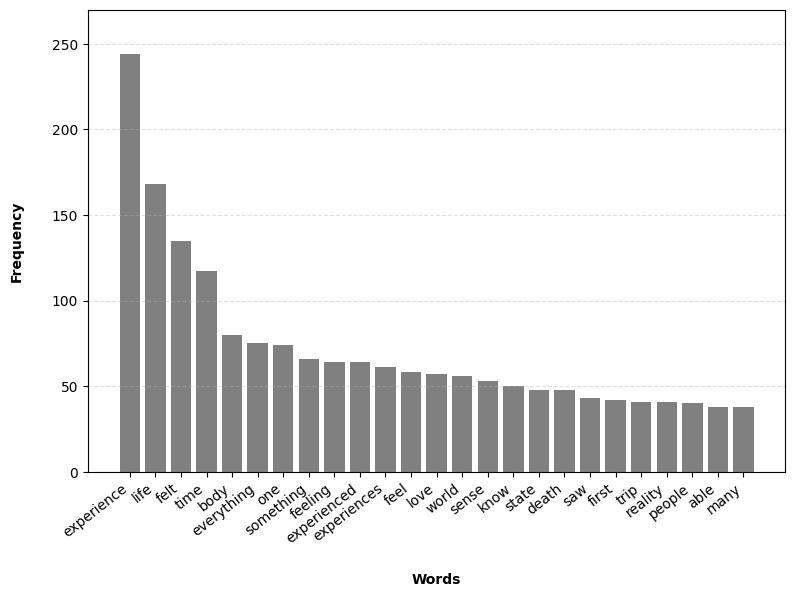

In [126]:
words, frequencies = zip(*top_25_words)

plt.figure(figsize=(9, 6))
plt.bar(words, frequencies, color="grey")
plt.xlabel("Words", fontweight="bold", fontsize=10, labelpad=20)
plt.ylabel("Frequency", fontweight="bold", fontsize=10, labelpad=20)
plt.xticks(rotation=38, ha="right", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.ylim(0, 270)

figure1_html = """
<p style="font-size: 14px">
    <strong>Figure 1.</strong> Frequency distribution of the top 25 most common words used in the analyzed descriptions (<i>N</i> = 338) excluding predefined stopwords.
</p>
"""
display(HTML(figure1_html))

plt.show()

## **Correlation analysis**

In [127]:
warnings.filterwarnings("ignore")

unique_tokens = set()
for text in df_english["description_text_EN"]:
    tokens = re.findall(r"\d\w*", text)
    unique_tokens.update(tokens)

numeric_starting_tokens = list(unique_tokens)

stopwords_list = list(stopwords)
stopwords_list.extend(numeric_starting_tokens)
    
vectorizer = CountVectorizer(stop_words=stopwords_list)
X = vectorizer.fit_transform(df_english["description_text_EN"])

word_features = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

df_combined = pd.concat([df_english[["MEQ_total_score"]], word_features], axis=1)

df_combined.head(10)

MEQ_total_score  abandoned  abilities  ability  able  absence  absolute  \
0              119          0          0        0     1        0         0   
1              130          0          0        0     0        0         0   
2               92          0          0        0     0        0         0   
3               77          0          0        0     0        0         0   
4               64          0          0        0     0        0         0   
5               26          0          0        0     0        0         0   
6               94          0          0        0     1        0         0   
7              116          0          0        0     0        0         0   
8               74          0          0        0     0        0         0   
9              114          0          0        0     0        0         0   

   absolutely  absorbing  abstract  abundance  abuse  abusing  abusive  abyss  \
0           0          0         0          0      0        0        0      0   
1           0          0         0          0      0        0        0      0   
2           0          0         0          0      0        0        0      0   
3           0          0         0          0      0        0        0      0   
4           0          0         0          0      0        0        0      0   
5           0          0         0          0      0        0        0      0   
6           0          0         0          0      0        0        0      0   
7           0          0         0          0      0        0        0      0   
8           0          0         0          0      0        0        0      0   
9           0          0         0          0      0        0        0      0   

   accent  accept  acceptance  accepted  accepting  access  accident  \
0       0       0           0         0          0       0         0   
1       0       0           0         0          0       0         0   
2       0       0           0         0          0       0         0   
3       0       0           0         0          0       0         0   
4       0       0           0         0          0       0         0   
5       0       0           0         0          0       0         0   
6       0       0           0         0          0       0         0   
7       0       0           0         0          0       0         0   
8       0       0           0         0          0       0         0   
9       0       0           0         0          0       0         0   

   accompanied  accompany  accompanying  accomplishment  acct  acha  achieve  \
0            0          0             0               0     0     0        0   
1            0          0             0               0     0     0        0   
2            0          0             0               0     0     0        0   
3            0          0             0               0     0     0        0   
4            0          0             0               0     0     0        0   
5            0          0             0               0     0     0        0   
6            0          0             0               0     0     0        0   
7            0          0             0               0     0     0        0   
8            0          0             0               0     0     0        0   
9            0          0             0               0     0     0        0   

   achieved  achieving  acid  acquainted  across  act  action  actions  \
0         0          0     0           0       0    0       0        0   
1         0          0     0           0       0    0       0        0   
2         0          0     0           0       0    0       0        0   
3         0          0     0           0       0    0       0        0   
4         0          0     0           0       0    0       0        0   
5         0          0     1           0       0    0       0        0   
6         0          0     0           0       0    0       

In [128]:
correlation_results = []

for col in word_features.columns:
    feature_data = df_combined[col]
    corr, p_value = pearsonr(df_combined["MEQ_total_score"].loc[feature_data.index], feature_data)
    
    if p_value < 0.05:
         correlation_results.append((col, f"{corr:.2f}", f"{p_value:.3f}"))

results_df = pd.DataFrame(correlation_results, columns=["Token", "Pearson's r", "p-value"])
results_df["Pearson's r"] = results_df["Pearson's r"].astype(float)

positive_R = results_df[results_df.apply(lambda x: x ["Pearson's r"] > 0, axis=1)]
negative_R = results_df[results_df.apply(lambda x: x ["Pearson's r"] < 0, axis=1)]

sorted_positive_R = positive_R.sort_values(by="Pearson's r", ascending=False)
sorted_negative_R = negative_R.sort_values(by="Pearson's r", ascending=True)

print(f"We've got {sorted_positive_R.shape[0]} words positively, and {sorted_negative_R.shape[0]} words negatively correlated with the MEQ30 scores.")

We've got 29 words positively, and 166 words negatively correlated with the MEQ30 scores.


In [129]:
sorted_positive_R.head(10)

,Token,Pearson's r,p-value
190,world,0.15,0.007
82,infinite,0.15,0.007
4,always,0.14,0.012
41,died,0.14,0.008
49,energy,0.14,0.012
76,heaven,0.13,0.018
161,stage,0.13,0.020
94,let,0.13,0.016
80,huge,0.13,0.018
192,years,0.13,0.019


In [130]:
sorted_negative_R.head(10)

,Token,Pearson's r,p-value
60,frightened,-0.21,0.000
53,example,-0.20,0.000
25,communion,-0.20,0.000
55,facts,-0.19,0.000
20,call,-0.19,0.001
12,bad,-0.18,0.001
139,recommend,-0.17,0.002
167,tachycardia,-0.17,0.002
127,pleasant,-0.17,0.001
181,unrealness,-0.17,0.002


### **Visualizing the correlations as word clouds**

In [131]:
width, height = 800, 500
ellipse_width = width * 0.85
ellipse_height = height * 0.9

mask = Image.new("L", (width, height), 255)
draw = ImageDraw.Draw(mask)

draw.ellipse(
    [(width // 2 - ellipse_width // 2, height // 2 - ellipse_height // 2),
     (width // 2 + ellipse_width // 2, height // 2 + ellipse_height // 2)],
    fill=0
)

mask.save("public/ellipse_mask.png")

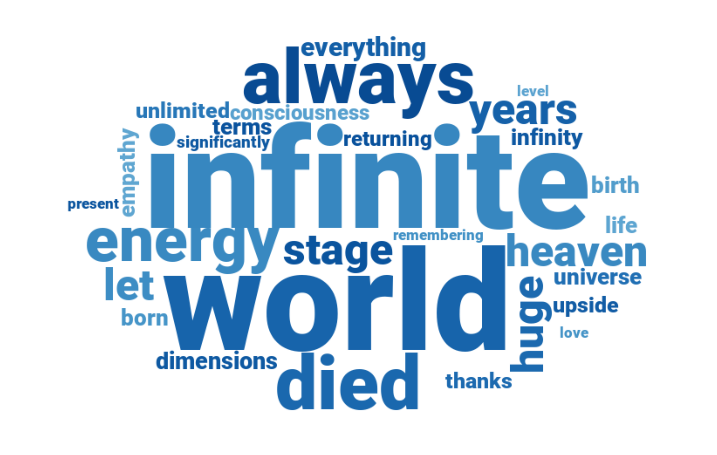

In [132]:
word_frequencies = dict(zip(sorted_positive_R["Token"], sorted_positive_R["Pearson's r"]))

blues = plt.cm.get_cmap("Blues")
start = 0.5
end = 0.9
edited_blues = LinearSegmentedColormap.from_list("new_blues", blues(np.linspace(start, end, 256)))

roboto_font = "public/fonts/Roboto/Roboto-Black.ttf"
mask_image = np.array(Image.open("public/ellipse_mask.png"))

wordcloud = WordCloud(
    width=800, 
    height=600,
    background_color="white",
    colormap=edited_blues,
    font_path=roboto_font,
    mask=mask_image
).generate_from_frequencies(word_frequencies)

plt.figure(figsize=(9, 6))
plt.imshow(wordcloud)
plt.axis("off")

figure2_html = """
<p style="font-size: 14px">
    <strong>Figure 2.</strong> Word cloud illustrating 29 words that are positively correlated with MEQ30 scores.
    Larger words represent stronger correlations, with correlation coefficient (<i>r</i>) ranging from 0.11 to 0.15 
    and <i>p</i>-values less than 0.05 for each word. The hue of the words was randomly assigned to enhance readability.
</p>
"""
display(HTML(figure2_html))

plt.show()

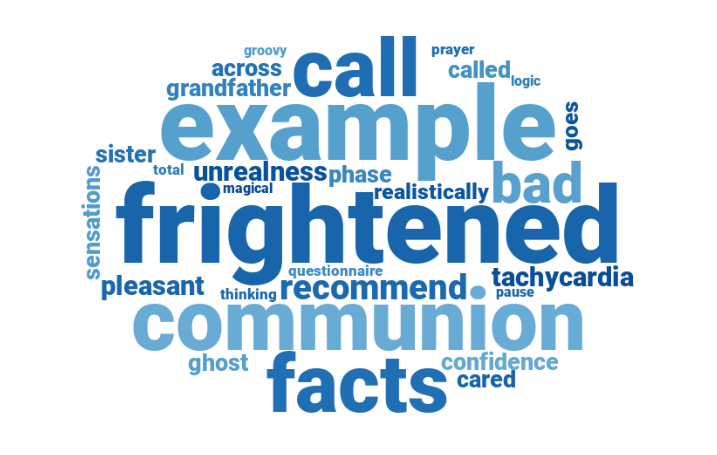

In [133]:
absolute_negative_R_values = sorted_negative_R["Pearson's r"].abs()

word_frequencies = dict(zip(sorted_negative_R["Token"], absolute_negative_R_values))
limited_word_frequencies = dict(list(word_frequencies.items())[:29])

blues = plt.cm.get_cmap("Blues")
start = 0.5
end = 0.9
edited_blues = LinearSegmentedColormap.from_list("new_blues", blues(np.linspace(start, end, 256)))

wordcloud = WordCloud(
    width=800, 
    height=400,
    background_color="white",
    colormap=edited_blues,
    font_path=roboto_font,
    mask=mask_image
).generate_from_frequencies(limited_word_frequencies)

plt.figure(figsize=(9, 6))
plt.imshow(wordcloud)
plt.axis("off")

figure3_html = """
<p style="font-size: 14px">
    <strong>Figure 3.</strong> Word cloud illustrating top 29 words that are negatively correlated with MEQ30 scores.
    Larger words represent stronger correlations, with correlation coefficient (<i>r</i>) ranging from -0.14 to -0.21 
    and <i>p</i>-values less than 0.05 for each word. The hue of the words was randomly assigned to enhance readability.
</p>
"""
display(HTML(figure3_html))

plt.show()

# **Emotional sentiment analysis**

## **Complete mystical experiences**

In [134]:
model_name = "arpanghoshal/EmoRoBERTa"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)

filtered_df_complete = df_english[df_english["MEQ_complete"] == 1]
descriptions_complete = filtered_df_complete["description_text_EN"].tolist()
sentiment_results_complete = []

batch_size = 32

for i in range(0, len(descriptions_complete), batch_size):
    batch = descriptions_complete[i:i + batch_size]
    results = sentiment_pipeline(batch)
    sentiment_results_complete.extend(results)

total_results = len(sentiment_results_complete)
print(f"\nNumber of chunks analyzed: {total_results}\n")

for idx, result in enumerate(sentiment_results_complete[:10]):
    print(f"Chunk {idx + 1}: {descriptions_complete[idx]}")
    print(f"Emotion: {result["label"]}\nScore: {result["score"]:.3f}\n")


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.



Number of chunks analyzed: 152

Chunk 1: After more than 72 hours without sleep during which I took large amounts of mdma, psilocybin and thc - when sleep finally came, I was practically one hundred percent conscious during it - I was the one who decided what was going to happen next, making decisions resulting from the internal dialogue. At one point, I felt incredible bliss and warmth and saw myself lying on the bed next to my partner - I could see myself, curiously looking at myself. This went on for about 5 maybe 10 minutes, during which I cried and rejoiced at the same time. It changed my life in the sense that I wondered what if, being in this state, I meet someone who is also in it? What will happen? Will we be able to communicate?
Emotion: sadness
Score: 0.349

Chunk 2: It cured me of ailments that doctors had been treating for 15 years without success
Emotion: approval
Score: 0.790

Chunk 3: Trip like trip, dream like dream. Who would want to listen to that?
Emotion: confusio

In [135]:
unique_labels = set(result["label"] for result in sentiment_results_complete)
label_counts = {label: 0 for label in unique_labels}

for result in sentiment_results_complete:
    label_counts[result["label"]] += result["score"]

emotion_data = [(label, label_counts[label]) for label in unique_labels]
total_score = sum(label_counts.values())
percentage_data_complete = [(label, (score / total_score) * 100) for label, score in emotion_data]

print("Aggregated emotion analysis results:\n")
for emotion, score in percentage_data_complete:
    print(f"{emotion.capitalize()}: {score:.2f}%")

Aggregated emotion analysis results:

Sadness: 2.93%
Optimism: 0.98%
Embarrassment: 0.53%
Admiration: 15.49%
Gratitude: 5.57%
Disappointment: 0.70%
Realization: 23.90%
Grief: 0.43%
Desire: 0.55%
Amusement: 0.32%
Excitement: 1.17%
Joy: 9.48%
Relief: 1.36%
Caring: 1.49%
Neutral: 9.85%
Surprise: 3.15%
Confusion: 1.11%
Love: 6.12%
Fear: 4.34%
Nervousness: 0.40%
Approval: 10.13%


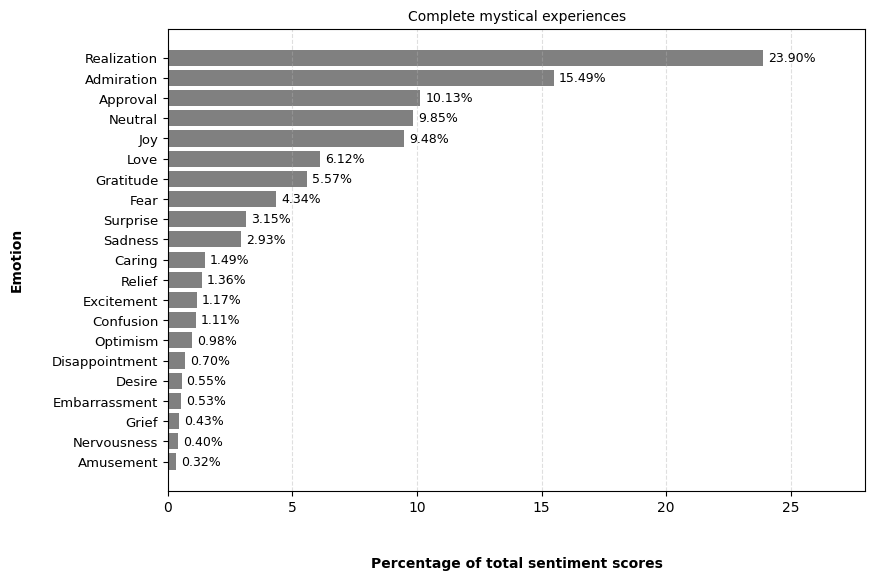

In [136]:
sorted_percentages = sorted(percentage_data_complete, key=lambda x: x[1], reverse=False)

emotion_names = [emotion[0].capitalize() for emotion in sorted_percentages]
percentage_labels = [emotion[1] for emotion in sorted_percentages]

plt.figure(figsize=(9, 6))
bars = plt.barh(emotion_names, percentage_labels, color="gray")
for bar in bars:
    plt.text(
        bar.get_width() + 0.2,
        bar.get_y() + bar.get_height()/2,
        f"{bar.get_width():.2f}%",
        va="center", 
        fontsize=9
    )
plt.title("Complete mystical experiences", fontsize=10)
plt.xlabel("Percentage of total sentiment scores", fontweight="bold", fontsize=10, labelpad=30)
plt.ylabel("Emotion", fontweight="bold", fontsize=10, labelpad=20)
plt.yticks(fontsize=9.5)
plt.xlim(0, 28)
plt.grid(axis="x", linestyle="--", alpha=0.4)

figure4_html = """
<p style="font-size: 14px">
    <strong>Figure 4.</strong> Bar plot illustrating the results of emotional sentiment analysis for participants 
    with complete mystical experience (<i>N</i> = 152). Descriptions were analyzed using the pre-trained EmoRoBERTa 
    machine learning model, which assigned a dominant emotion and assesed its intensity on 0 to 1 scale for each description. 
    The scores were aggregated, and proportions of each emotion label were calculated.
</p>
"""
display(HTML(figure4_html))

plt.show()

In [137]:
positive_emotions = [
    "realization", "admiration", "caring", "joy", 
    "love", "relief", "desire", "excitement", 
    "pride", "approval", "optimism", "gratitude", "amusement"
]
neutral_emotions =[
    "neutral", "surprise"
]
negative_emotions = [
    "grief", "confusion", "fear", "annoyance", 
    "sadness", "nervousness", "remorse", "disappointment"
]

percentage_tuples_complete = [(emotion, round(score, 3)) for emotion, score in percentage_data_complete]

percentage_tuples_complete

[('sadness', 2.932),
 ('optimism', 0.979),
 ('embarrassment', 0.527),
 ('admiration', 15.487),
 ('gratitude', 5.568),
 ('disappointment', 0.703),
 ('realization', 23.895),
 ('grief', 0.434),
 ('desire', 0.552),
 ('amusement', 0.323),
 ('excitement', 1.165),
 ('joy', 9.478),
 ('relief', 1.365),
 ('caring', 1.491),
 ('neutral', 9.855),
 ('surprise', 3.153),
 ('confusion', 1.111),
 ('love', 6.115),
 ('fear', 4.337),
 ('nervousness', 0.399),
 ('approval', 10.131)]

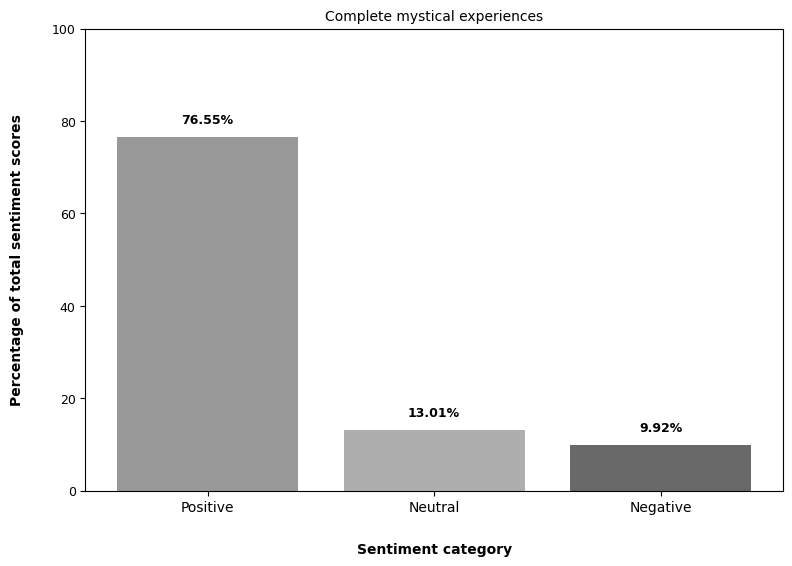

In [138]:
positive_score = sum(
    score for emotion, score in percentage_data_complete 
    if emotion in positive_emotions
)
neutral_score = sum(
    score for emotion, score in percentage_data_complete 
    if emotion in neutral_emotions
)
negative_score = sum(
    score for emotion, score in percentage_data_complete 
    if emotion in negative_emotions
)

categories = ["Positive", "Neutral", "Negative"]
scores = [positive_score, neutral_score, negative_score]

plt.figure(figsize=(9, 6))
bars = plt.bar(categories, scores, color=["#999999", "#AEAEAE", "#696969"])
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 3,
        f"{height:.2f}%",
        ha="center",
        fontsize=9,
        fontweight="bold",
    )
plt.title("Complete mystical experiences", fontsize=10)
plt.xlabel("Sentiment category", fontweight="bold", fontsize=10, labelpad=20)
plt.ylabel("Percentage of total sentiment scores", fontweight="bold", fontsize=10, labelpad=20)
plt.yticks(fontsize=9)
plt.xticks(fontsize=10)
plt.ylim(0, 100)

figure5_html = """
<p style="font-size: 14px">
    <strong>Figure 5.</strong> Bar plot showing the proportions of positive, negative, and neutral sentiments 
    in descriptions provided by participants who experienced a complete mystical experience (<i>N</i> = 152).
</p>
"""
display(HTML(figure5_html))

plt.show()

## **Non-complete mystical experiences**

In [139]:
model_name = "arpanghoshal/EmoRoBERTa"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)

filtered_df_non_complete = df_english[df_english["MEQ_complete"] == 0]
descriptions_non_complete = filtered_df_non_complete["description_text_EN"].tolist()
sentiment_results_non_complete = []

batch_size = 32

for i in range(0, len(descriptions_non_complete), batch_size):
    batch = descriptions_non_complete[i:i + batch_size]
    results = sentiment_pipeline(batch)
    sentiment_results_non_complete.extend(results)

total_results = len(sentiment_results_non_complete)
print(f"\nNumber of chunks analyzed: {total_results}\n")


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.



Number of chunks analyzed: 186



In [140]:
unique_labels = set(result["label"] for result in sentiment_results_non_complete)
label_counts = {label: 0 for label in unique_labels}

for result in sentiment_results_non_complete:
    label_counts[result["label"]] += result["score"]

emotion_data = [(label, label_counts[label]) for label in unique_labels]
total_score = sum(label_counts.values())
percentage_data_non_complete = [(label, (score / total_score) * 100) for label, score in emotion_data]

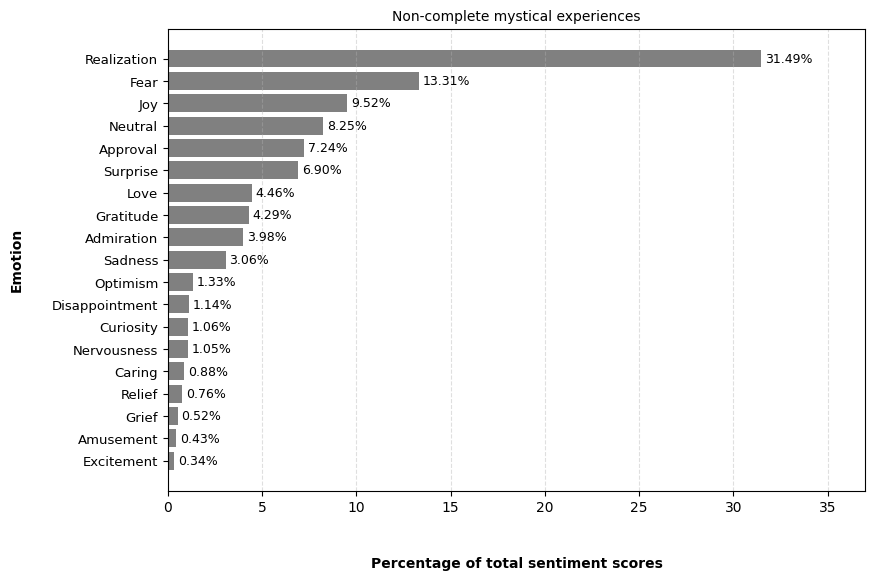

In [146]:
sorted_percentages = sorted(percentage_data_non_complete, key=lambda x: x[1], reverse=False)

emotion_names = [emotion[0].capitalize() for emotion in sorted_percentages]
percentage_labels = [emotion[1] for emotion in sorted_percentages]

plt.figure(figsize=(9, 6))
bars = plt.barh(emotion_names, percentage_labels, color="gray")
for bar in bars:
    plt.text(
        bar.get_width() + 0.2,
        bar.get_y() + bar.get_height()/2,
        f"{bar.get_width():.2f}%",
        va="center", 
        fontsize=9
    )
plt.title("Non-complete mystical experiences", fontsize=10)
plt.xlabel("Percentage of total sentiment scores", fontweight="bold", fontsize=10, labelpad=30)
plt.ylabel("Emotion", fontweight="bold", fontsize=10, labelpad=20)
plt.yticks(fontsize=9.5)
plt.xlim(0, 37)
plt.grid(axis="x", linestyle="--", alpha=0.4)

figure6_html = """
<p style="font-size: 14px">
    <strong>Figure 6.</strong> Bar plot illustrating the results of emotional sentiment analysis for participants 
    with non-complete mystical experience (<i>N</i> = 186). Descriptions were analyzed using the pre-trained EmoRoBERTa 
    machine learning model, which assigned a dominant emotion and assesed its intensity on 0 to 1 scale for each description. 
    The scores were aggregated, and proportions of each emotion label were calculated.
</p>
"""
display(HTML(figure6_html))

plt.show()

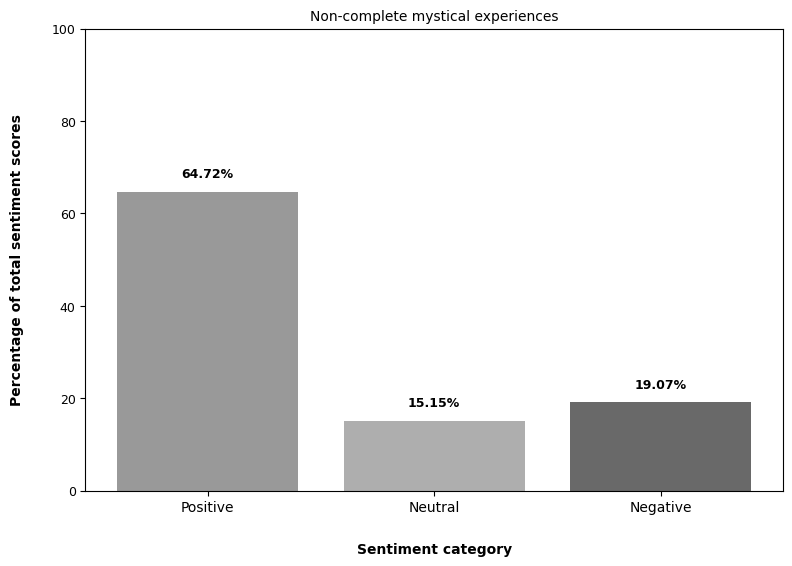

In [142]:
percentage_tuples_non_complete = [(emotion, round(score, 3)) for emotion, score in percentage_data_non_complete]

positive_score = sum(
    score for emotion, score in percentage_data_non_complete 
    if emotion in positive_emotions
)
neutral_score = sum(
    score for emotion, score in percentage_data_non_complete 
    if emotion in neutral_emotions
)
negative_score = sum(
    score for emotion, score in percentage_data_non_complete 
    if emotion in negative_emotions
)

categories = ["Positive", "Neutral", "Negative"]
scores = [positive_score, neutral_score, negative_score]

plt.figure(figsize=(9, 6))
bars = plt.bar(categories, scores, color=["#999999", "#AEAEAE", "#696969"])
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 3,
        f"{height:.2f}%",
        ha="center",
        fontsize=9,
        fontweight="bold",
    )
plt.title("Non-complete mystical experiences", fontsize=10)
plt.xlabel("Sentiment category", fontweight="bold", fontsize=10, labelpad=20)
plt.ylabel("Percentage of total sentiment scores", fontweight="bold", fontsize=10, labelpad=20)
plt.yticks(fontsize=9)
plt.xticks(fontsize=10)
plt.ylim(0, 100)

figure7_html = """
<p style="font-size: 14px">
    <strong>Figure 7.</strong> Bar plot showing the proportions of positive, negative, and neutral sentiments 
    in descriptions provided by participants who experienced a non-complete mystical experience (<i>N</i> = 186).
</p>
"""
display(HTML(figure7_html))

plt.show()


# **Participants' subjective assesment of the influence of the experience**

In [165]:
influence_columns = [col for col in df_english.columns if col.startswith("influence")]

replacement_mapping = {
    1: "Definitely positive",
    2: "Rather positive",
    3: "No influence",
    4: "Rather negative",
    5: "Definitely negative"   
}

df_english[influence_columns] = df_english[influence_columns].replace(replacement_mapping)

In [166]:
filtered_df_complete = df_english[df_english["MEQ_complete"] == 1]
filtered_df_non_complete = df_english[df_english["MEQ_complete"] == 0]

influence_values_complete = filtered_df_complete["influence_fear"].value_counts()
influence_values_non_complete = filtered_df_non_complete["influence_fear"].value_counts()

total_complete = influence_values_complete.sum()
total_non_complete = influence_values_non_complete.sum()

complete_percentages = (influence_values_complete / total_complete) * 100
non_complete_percentages = (influence_values_non_complete / total_non_complete) * 100

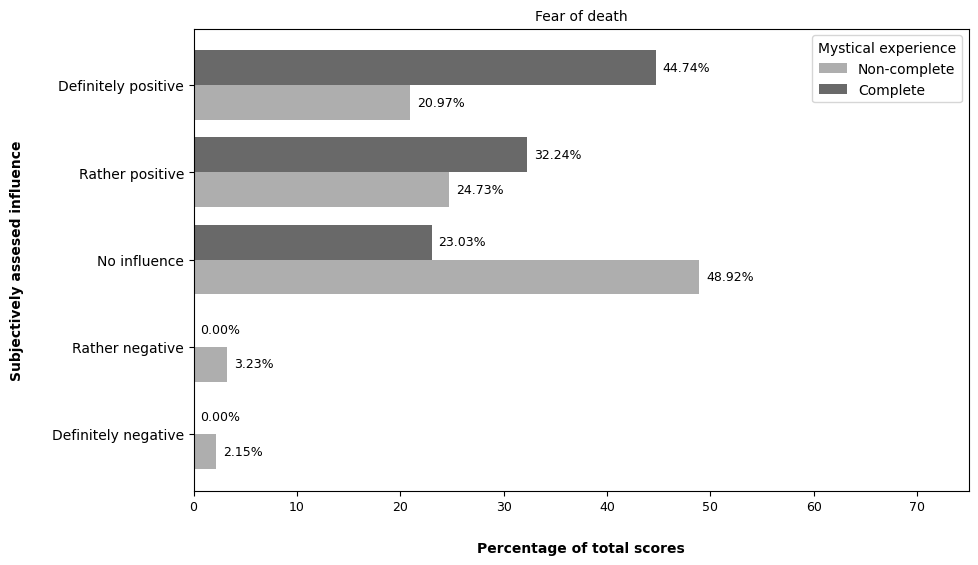

In [167]:
index = ["Definitely negative", "Rather negative", "No influence", "Rather positive", "Definitely positive"]

complete_percentages = complete_percentages.reindex(index, fill_value=0)
non_complete_percentages = non_complete_percentages.reindex(index, fill_value=0)

df = pd.DataFrame({
    "Non-complete": non_complete_percentages,
    "Complete": complete_percentages
})

fig, ax = plt.subplots(figsize=(10, 6))

bars = df.plot(kind="barh", ax=ax, width=0.8, position=0.5, color=["#AEAEAE", "#696969"])
for container in bars.containers:
    ax.bar_label(
        container, 
        fmt="%.2f%%", 
        label_type="edge", 
        padding=5,
        fontsize=9
    )
    
plt.title("Fear of death", fontsize=10)
plt.xlabel("Percentage of total scores", fontweight="bold", fontsize=10, labelpad=20)
plt.ylabel("Subjectively assesed influence", fontweight="bold", fontsize=10, labelpad=20)
plt.legend(title="Mystical experience")
plt.yticks(fontsize=10)
plt.xticks(fontsize=9)
plt.xlim(0, 75)

plt.show()

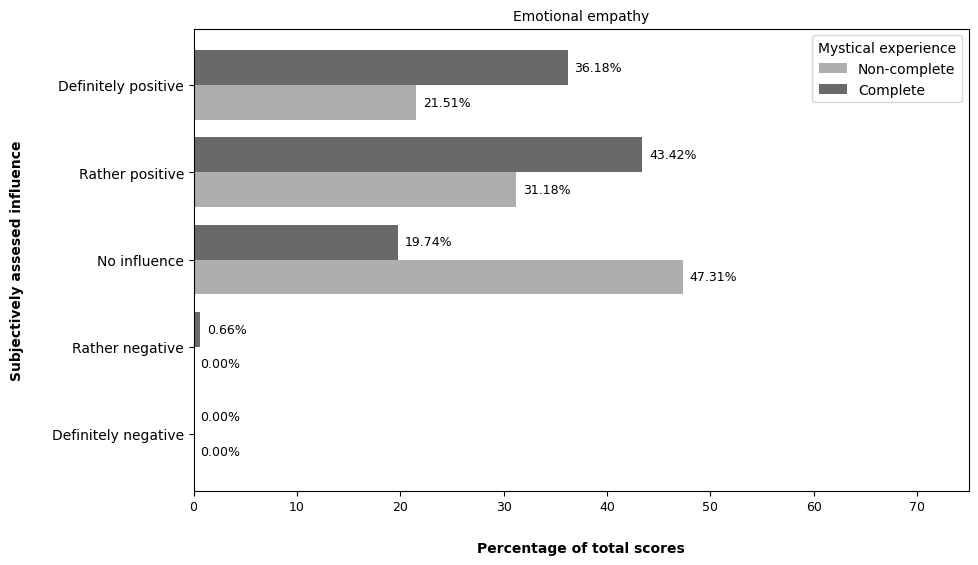

In [161]:
influence_values_complete = filtered_df_complete["influence_empathy"].value_counts()
influence_values_non_complete = filtered_df_non_complete["influence_empathy"].value_counts()

total_complete = influence_values_complete.sum()
total_non_complete = influence_values_non_complete.sum()

complete_percentages = (influence_values_complete / total_complete) * 100
non_complete_percentages = (influence_values_non_complete / total_non_complete) * 100

index = ["Definitely negative", "Rather negative", "No influence", "Rather positive", "Definitely positive"]

complete_percentages = complete_percentages.reindex(index, fill_value=0)
non_complete_percentages = non_complete_percentages.reindex(index, fill_value=0)

df = pd.DataFrame({
    "Non-complete": non_complete_percentages,
    "Complete": complete_percentages
})

fig, ax = plt.subplots(figsize=(10, 6))

bars = df.plot(kind="barh", ax=ax, width=0.8, position=0.5, color=["#AEAEAE", "#696969"])
for container in bars.containers:
    ax.bar_label(
        container, 
        fmt="%.2f%%", 
        label_type="edge", 
        padding=5,
        fontsize=9
    )
    
plt.title("Emotional empathy", fontsize=10)
plt.xlabel("Percentage of total scores", fontweight="bold", fontsize=10, labelpad=20)
plt.ylabel("Subjectively assesed influence", fontweight="bold", fontsize=10, labelpad=20)
plt.legend(title="Mystical experience")
plt.yticks(fontsize=10)
plt.xticks(fontsize=9)
plt.xlim(0, 75)

plt.show()

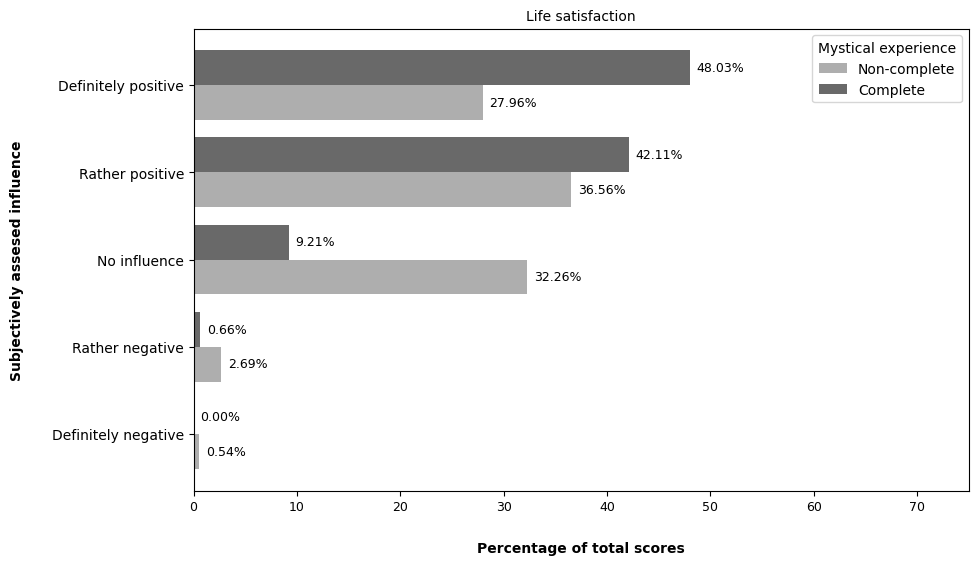

In [162]:
influence_values_complete = filtered_df_complete["influence_satisfaction"].value_counts()
influence_values_non_complete = filtered_df_non_complete["influence_satisfaction"].value_counts()

total_complete = influence_values_complete.sum()
total_non_complete = influence_values_non_complete.sum()

complete_percentages = (influence_values_complete / total_complete) * 100
non_complete_percentages = (influence_values_non_complete / total_non_complete) * 100

index = ["Definitely negative", "Rather negative", "No influence", "Rather positive", "Definitely positive"]

complete_percentages = complete_percentages.reindex(index, fill_value=0)
non_complete_percentages = non_complete_percentages.reindex(index, fill_value=0)

df = pd.DataFrame({
    "Non-complete": non_complete_percentages,
    "Complete": complete_percentages
})

fig, ax = plt.subplots(figsize=(10, 6))

bars = df.plot(kind="barh", ax=ax, width=0.8, position=0.5, color=["#AEAEAE", "#696969"])
for container in bars.containers:
    ax.bar_label(
        container, 
        fmt="%.2f%%", 
        label_type="edge", 
        padding=5,
        fontsize=9
    )
    
plt.title("Life satisfaction", fontsize=10)
plt.xlabel("Percentage of total scores", fontweight="bold", fontsize=10, labelpad=20)
plt.ylabel("Subjectively assesed influence", fontweight="bold", fontsize=10, labelpad=20)
plt.legend(title="Mystical experience")
plt.yticks(fontsize=10)
plt.xticks(fontsize=9)
plt.xlim(0, 75)

plt.show()